# Lick model

### This notebook is an initial attempt to model trains of licks when rats are choosing between two solutions (e.g. protein and carbohydrate)

In [34]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
%run helperfx

In [35]:
use_real_data = False
simulate_data = True
fit_data = False

# set parameters for simulated data
PP = 0.5
tau = 10

# set bounds for fitting data
bounds = {'PP':[0, 1, 10], 'tau':[0.5, 20, 10]}


if use_real_data and simulate_data:
    print('Over-riding simulate_data because use_real_data is selected.')
    simulate_data = False

In [36]:
# This function will be called when simulating test data and data for performing fits

def runmodel(PP, tau, nruns):
    
    # Create system with vars of interest
    System = {}
    System['PP'] = PP
    System['tau'] = tau
    System['licksinburst'] = 0
    
    # Initializes array for storing data
    output = [0.5]

    for i in range(1, nruns):
        update_func(System, output)

    # print(np.mean([x-1 for x in licks if x>0]))
    
    return output

In [37]:
def update_func(System, licks):
    pp = System['PP']
    tau = System['tau']
    x = System['licksinburst']
    
    if licks[-1] == 0.5:
            if random.random() < pp:
                licks.append(1)            
            else:
                licks.append(0)
            System['licksinburst'] = x+1
    else:
        p_cont = math.exp(-x*(1/tau))
        if random.random() < p_cont:           
            licks.append(licks[-1])
            System['licksinburst'] = x+1
        else:
            licks.append(0.5)
            System['licksinburst'] = 0          

In [39]:
def fit_data(lickdata, bounds, bins, nruns=1000):
    print('Fitting data using bounds provided.')
    
    data = lickdata['hists'][0][0]
    
    nPP = bounds['PP'][2]
    ntau = bounds['tau'][2]
    
    grid = np.empty((nPP,ntau,))
    
    pp_matrix = np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][1]/bounds['PP'][2])
    tau_matrix = np.arange(bounds['tau'][0], bounds['tau'][1], bounds['tau'][1]/bounds['tau'][2])

    print(tau_matrix)
    
    for pp_idx, pp in enumerate(pp_matrix):
        for tau_idx, tau in enumerate(tau_matrix):
            comparison_data = runmodel(pp, tau, nruns)
            licks_to_fit = analyse_licks(comparison_data, bins)
            
            #work out loglik for hist bins using compare function and place this value in the grid
            
            comp = licks_to_fit['hists'][0][0]
            
            diffs = [np.abs(x-y) for x,y in zip(data, comp)]
            
            grid[pp_idx, tau_idx] = sum(diffs)
            
    return grid

In [40]:
# Code to get data to be tested - either real or simulated    
    
# in future this will allow one to select subjects and experiments by including arguments for medfile location etc    
if use_real_data:
    %run extractlicks.ipynb
    licks = test1_data_NR['IPP3.2']

if simulate_data:
    print('Simulating data with values: PP...')
    licks = runmodel(PP, tau, 1000)

Simulating data with values: PP...


In [41]:
def analyse_licks(data, bins):
    
    burstarray = []
    tmp = []
    for i, x in enumerate(data):
        if x == 0.5:
            burstarray.append(tmp)
            tmp = []
        else:
            tmp.append(x)
    
    bursts = []
    hists = []
    cumsums = []
    
    for code in [0, 1]: 
        b = [len(x) for x in burstarray[1:] if x[0]==code]
        h = np.histogram(b, bins=bins) # add binsize
        cs = np.cumsum(h[0])
        
        bursts.append(b)
        hists.append(h)
        cumsums.append(cs)
    
    return ({'licks':data, 'bursts':bursts, 'hists':hists, 'cumsums':cumsums})

In [42]:
bins = np.arange(0,100)
lickdata = analyse_licks(licks, bins)

In [43]:
gridscores = fit_data(lickdata, bounds, bins)

gridscores

Fitting data using bounds provided.
[ 0.5  2.5  4.5  6.5  8.5 10.5 12.5 14.5 16.5 18.5]


array([[523., 286., 210., 141., 115.,  96.,  89.,  79.,  79.,  67.],
       [473., 267., 171., 122., 103.,  72.,  66.,  59.,  50.,  70.],
       [430., 243., 144., 111.,  77.,  46.,  47.,  46.,  38.,  49.],
       [369., 224., 127.,  76.,  48.,  31.,  37.,  36.,  43.,  31.],
       [319., 183., 122.,  74.,  36.,  38.,  25.,  37.,  43.,  43.],
       [272., 150.,  78.,  61.,  39.,  16.,  36.,  61.,  43.,  45.],
       [221., 112.,  72.,  46.,  37.,  32.,  32.,  51.,  47.,  51.],
       [179., 112.,  58.,  46.,  32.,  50.,  49.,  57.,  48.,  66.],
       [133.,  97.,  56.,  51.,  49.,  61.,  71.,  72.,  75.,  84.],
       [122.,  76.,  76.,  84.,  85.,  74.,  86.,  88.,  92.,  85.]])

612

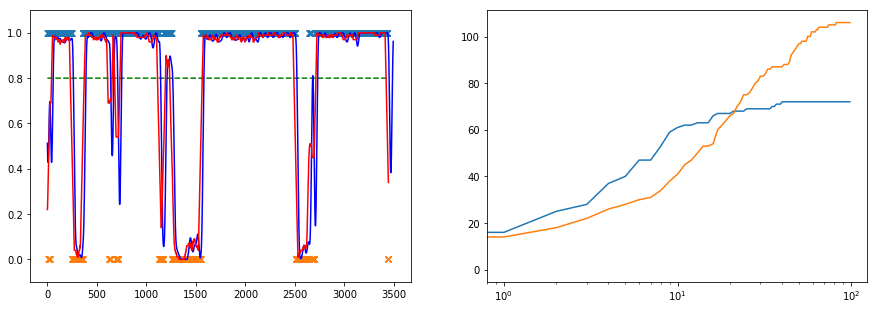

In [34]:
f, ax = plt.subplots(figsize=(15,5), ncols=2)

x1 = [i for i, x in enumerate(licks) if x == 1]
x2 = [i for i, x in enumerate(licks) if x == 0]

y1 = [1]*len(x1)
y2 = [0]*len(x2)

ax[0].plot(x1,y1, 'x')
ax[0].plot(x2,y2, 'x')
try:
    ax[0].plot(np.arange(0,len(licks)),[PP]*len(licks), 'g', linestyle='dashed')
except:
    pass

ax[0].plot(smooth(licks, 50), 'b')
ax[0].plot(smooth2(licks, 50), 'r')

ax[0].set_ylim([-0.1, 1.1])


bins = np.arange(1,20)
ax[1].plot(lickdict['cumsums'][0])
ax[1].plot(lickdict['cumsums'][1])
ax[1].set_xticks([0, 5, 10, 15])
ax[1].set_xscale('log')
len(x2)

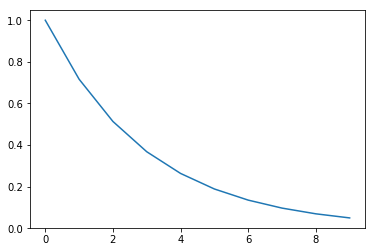

In [9]:
f, ax = plt.subplots()

lick_array = np.arange(0,10)
k=3
next_lick_p = [math.exp(-x*(1/k)) for x in lick_array]

ax.plot(lick_array, next_lick_p)



In [11]:
%who_ls dict

['lickdict', 'test1_data_NR', 'test1_data_PR']